In [33]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast 

import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import pandas as pd
from pathlib import Path
import tensorflow_io as tfio
import ast
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from tensorflow import keras 



**Build Data Loading Function**

In [34]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

**Create Tensorflow Dataset**

In [35]:
SOUND = os.path.join('..', 'Generator', 'audiodata')
SOUND

'..\\Generator_two\\audiodata'

In [36]:
import glob
import re

txtfiles = []
for file in glob.glob(SOUND+"\*.wav"):
    txtfiles.append(file)
txtfiles
sound = sorted(txtfiles, key=lambda s: int(re.search(r'\d+', s).group()))

In [37]:
values = pd.read_csv('../Generator/audiodata/data.csv')['note'].tolist()
note = list()
for value in values:
    if value == 'a':
        note.append(tf.one_hot(0,7))
    if value == 'b':
        note.append(tf.one_hot(1,7))
    if value == 'c':
        note.append(tf.one_hot(2,7))
    if value == 'd':
        note.append(tf.one_hot(3,7))
    if value == 'e':
        note.append(tf.one_hot(4,7))
    if value == 'f':
        note.append(tf.one_hot(5,7))
    if value == 'g':
        note.append(tf.one_hot(6,7))

values = pd.read_csv('../Generator_two/audiodata/data.csv')['osc'].tolist()
osc = list()
for value in values:
    if value == 'sine':
        osc.append(tf.one_hot(0,4))
    if value == 'square':
        osc.append(tf.one_hot(1,4))
    if value == 'sawtooth':
        osc.append(tf.one_hot(2,4))
    if value == 'triangle':
        osc.append(tf.one_hot(3,4))

mod = pd.read_csv('../Generator_two/audiodata/data.csv')['mod'].tolist()
attack = pd.read_csv('../Generator_two/audiodata/data.csv')['attack'].tolist()
decay = pd.read_csv('../Generator_two/audiodata/data.csv')['decay'].tolist()
sustain = pd.read_csv('../Generator_two/audiodata/data.csv')['sustain'].tolist()
release = pd.read_csv('../Generator_two/audiodata/data.csv')['release'].tolist()


data = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(sound), tf.data.Dataset.from_tensor_slices((note, osc, mod, attack, decay, sustain, release))))

**Build Preprocessing Function to Convert to Spectrogram**

In [38]:
def preprocess(file_path, lable): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:63901] 
    zero_padding = tf.zeros([63901] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, lable

**Create Training and Testing Partitions**

In [39]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [40]:
train = data.take(875)
test = data.skip(875).take(375)

**Build Model**

In [41]:
inputs = keras.Input(shape=(497, 257,1))
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)

x_note = Dense(128, activation='relu')(x)
x_osc = Dense(128, activation='relu')(x)
x_mod = Dense(128, activation='relu')(x)
x_attack = Dense(128, activation='relu')(x)
x_decay = Dense(128, activation='relu')(x)
x_sustain = Dense(128, activation='relu')(x)
x_release = Dense(128, activation='relu')(x)


output_note = Dense(7, activation='softmax', name='note')(x_note)
output_osc = Dense(4, activation='softmax', name='osc')(x_osc)
output_mod = Dense(1, activation='linear', name='mod')(x_mod)
output_attack = Dense(1, activation='linear', name='attack')(x_attack)
output_decay = Dense(1, activation='linear', name='decay')(x_decay)
output_sustain = Dense(1, activation='linear', name='sustain')(x_sustain)
output_release = Dense(1, activation='linear', name='release')(x_release)

model = keras.Model(inputs=inputs,outputs=[output_note,output_osc, output_mod, output_attack, output_decay, output_sustain, output_release])

In [42]:
losses = {'note': 'categorical_crossentropy', 'osc': 'categorical_crossentropy', 'mod': 'mse', 'attack': 'mse', 'decay': 'mse', 'sustain': 'mse', 'release': 'mse'}
model.compile(optimizer=tf.keras.optimiz    ers.Adam(learning_rate=1e-3), loss=losses, metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [43]:
model.summary() 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 497, 257, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 495, 255, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 493, 253, 32  9248        ['conv2d_12[0][0]']              
                                )                                                           

**Train**

In [44]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
875/875 [==============================] - 3848s 4s/step - loss: 2.0252 - note_loss: 0.2360 - osc_loss: 0.5921 - mod_loss: 0.8538 - attack_loss: 0.0648 - decay_loss: 0.0844 - sustain_loss: 0.0712 - release_loss: 0.1230 - note_recall_5: 0.8719 - note_precision_5: 0.9937 - osc_recall_5: 0.6611 - osc_precision_5: 0.8492 - mod_recall_5: 0.9907 - mod_precision_5: 0.9735 - attack_recall_5: 0.4803 - attack_precision_5: 0.9999 - decay_recall_5: 0.4223 - decay_precision_5: 1.0000 - sustain_recall_5: 0.4675 - sustain_precision_5: 1.0000 - release_recall_5: 0.4329 - release_precision_5: 0.9998 - val_loss: 0.5057 - val_note_loss: 0.0132 - val_osc_loss: 0.2157 - val_mod_loss: 0.1341 - val_attack_loss: 0.0111 - val_decay_loss: 0.0509 - val_sustain_loss: 0.0157 - val_release_loss: 0.0651 - val_note_recall_5: 0.9977 - val_note_precision_5: 0.9997 - val_osc_recall_5: 0.8775 - val_osc_precision_5: 0.8897 - val_mod_recall_5: 1.0000 - val_mod_precision_5: 0.9940 - val_attack_recall_5: 0.4688 - v

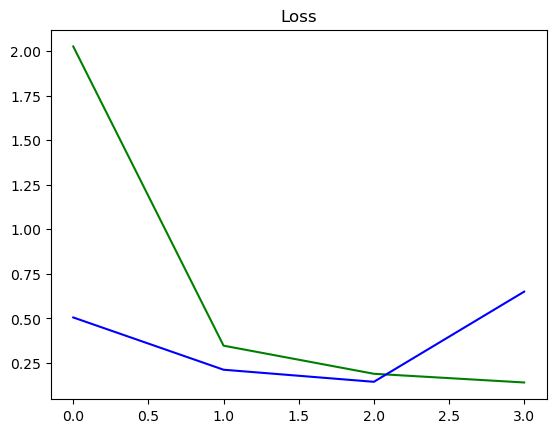

In [77]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'g')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

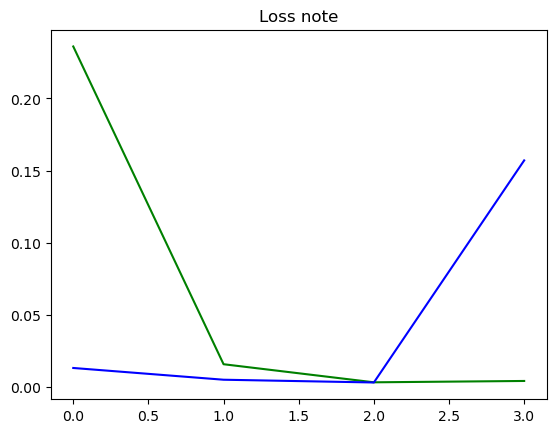

In [45]:
plt.title('Loss note')
plt.plot(hist.history['note_loss'], 'g')
plt.plot(hist.history['val_note_loss'], 'b')
plt.show()

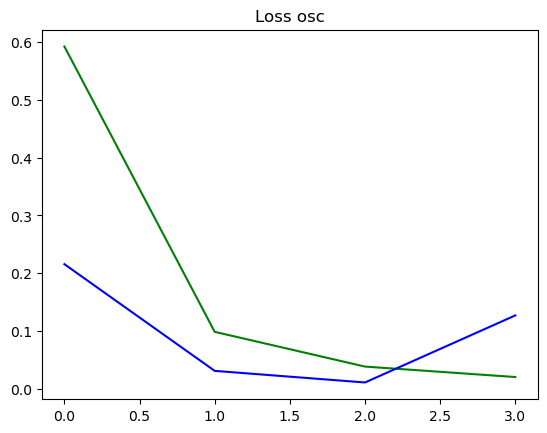

In [46]:
plt.title('Loss osc')
plt.plot(hist.history['osc_loss'], 'g')
plt.plot(hist.history['val_osc_loss'], 'b')
plt.show()

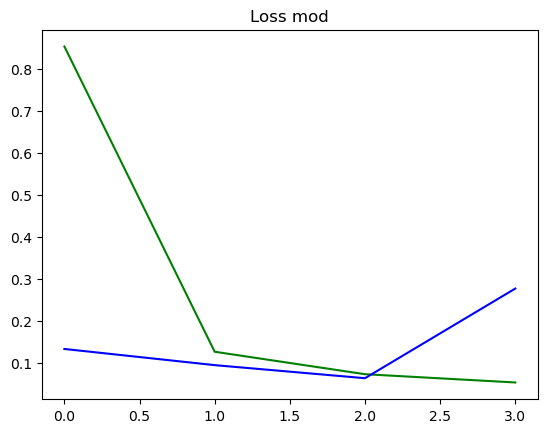

In [47]:
plt.title('Loss mod')
plt.plot(hist.history['mod_loss'], 'g')
plt.plot(hist.history['val_mod_loss'], 'b')
plt.show()

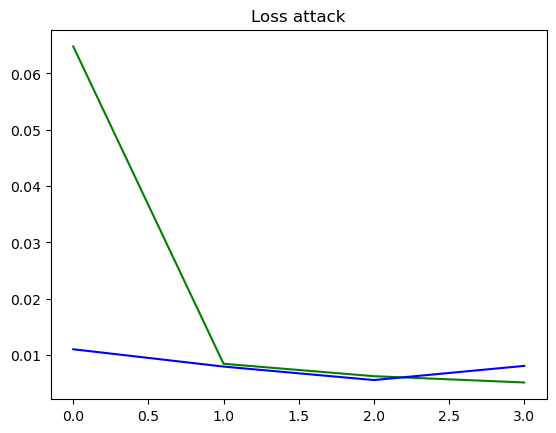

In [48]:
plt.title('Loss attack')
plt.plot(hist.history['attack_loss'], 'g')
plt.plot(hist.history['val_attack_loss'], 'b')
plt.show()

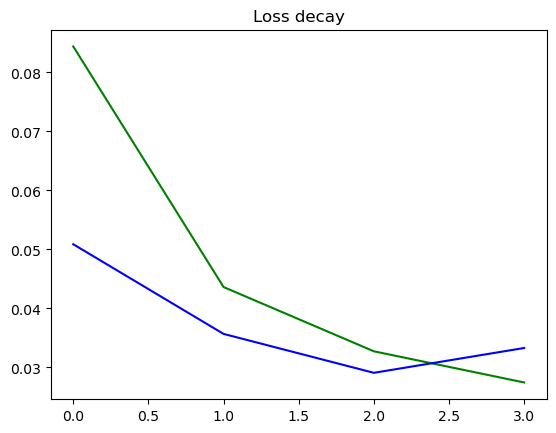

In [49]:
plt.title('Loss decay')
plt.plot(hist.history['decay_loss'], 'g')
plt.plot(hist.history['val_decay_loss'], 'b')
plt.show()

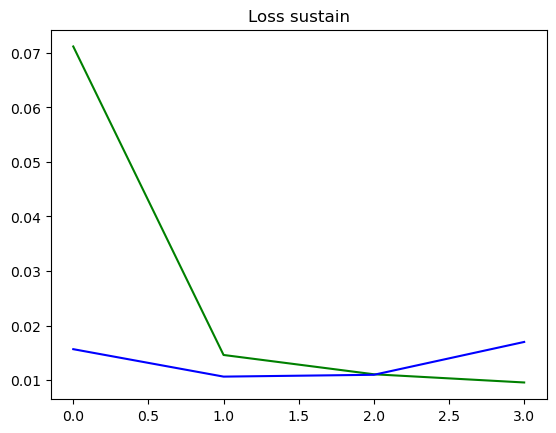

In [50]:
plt.title('Loss sustain')
plt.plot(hist.history['sustain_loss'], 'g')
plt.plot(hist.history['val_sustain_loss'], 'b')
plt.show()

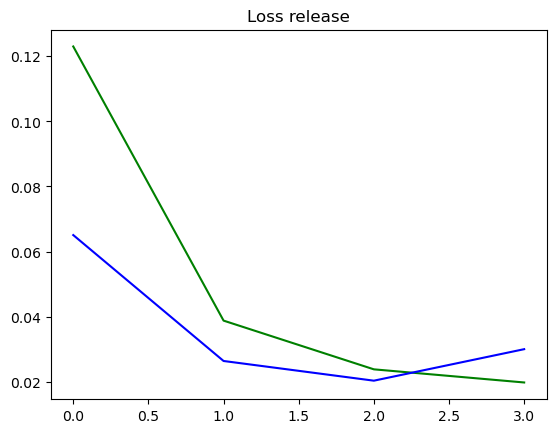

In [51]:
plt.title('Loss release')
plt.plot(hist.history['release_loss'], 'g')
plt.plot(hist.history['val_release_loss'], 'b')
plt.show()

**Test Model with a Single Clip**

In [60]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [62]:
#note
y_test[0]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [63]:
#note
yhat[0]

array([[1.14688156e-23, 8.80799607e-21, 1.00000000e+00, 1.57777957e-11,
        3.77050889e-14, 1.12023455e-20, 2.18002279e-22],
       [1.01170999e-05, 5.13047644e-06, 1.58677352e-07, 2.18835561e-10,
        3.89901834e-05, 3.59703839e-01, 6.40241742e-01],
       [6.00321821e-18, 1.80183396e-17, 4.09273044e-33, 7.46529130e-24,
        6.20981294e-13, 9.99999881e-01, 1.34364939e-07],
       [2.30612063e-09, 6.03573386e-18, 1.11125344e-21, 1.27798225e-20,
        4.05128410e-20, 3.91207164e-15, 1.00000000e+00],
       [8.53459994e-07, 7.65367133e-07, 3.48592238e-23, 2.91264544e-13,
        1.63493269e-07, 9.96043801e-01, 3.95446131e-03],
       [7.00806879e-09, 1.65284582e-05, 1.41354739e-09, 9.98943388e-01,
        1.04011013e-03, 4.87234342e-09, 4.68386163e-10],
       [9.99836087e-01, 5.28640021e-09, 1.22543331e-27, 4.00812201e-19,
        7.48801114e-20, 8.14202425e-14, 1.63907491e-04],
       [7.12488660e-20, 2.47912163e-10, 2.26229839e-19, 1.00000000e+00,
        3.55872775e-12, 2

In [64]:
#osc
y_test[1]

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [65]:
#osc
yhat[1]

array([[9.2548561e-27, 9.5739197e-05, 5.8864814e-16, 9.9990427e-01],
       [7.1250620e-26, 2.4689955e-04, 9.9975306e-01, 3.6682553e-11],
       [5.0069658e-34, 1.0000000e+00, 1.6600584e-12, 1.1015334e-10],
       [1.1085230e-25, 9.9906439e-01, 9.3561044e-04, 2.9605647e-13],
       [4.3969742e-17, 1.3165964e-02, 5.1925462e-13, 9.8683399e-01],
       [9.8238879e-01, 2.3581680e-04, 9.9624775e-10, 1.7375361e-02],
       [9.8218900e-01, 6.9699519e-05, 4.2083633e-12, 1.7741319e-02],
       [1.2284271e-22, 3.2076315e-08, 3.3662799e-26, 1.0000000e+00],
       [1.7515035e-14, 9.0003964e-03, 1.1747028e-13, 9.9099964e-01],
       [9.9768102e-01, 1.3162627e-05, 2.8330658e-13, 2.3058408e-03],
       [3.7623906e-07, 5.0202953e-03, 1.9034092e-11, 9.9497932e-01],
       [9.5852134e-26, 9.9020267e-01, 9.7972723e-03, 1.4648635e-18],
       [3.0655284e-17, 5.0610844e-03, 9.9492490e-01, 1.4029799e-05],
       [1.7777273e-15, 1.8986599e-03, 4.7438247e-12, 9.9810141e-01],
       [9.9996901e-01, 1.1863405e-

In [66]:
#mod
y_test[2]

array([ 3,  7,  5, 10,  2,  7,  4,  5,  9,  4,  5,  8, 10, 10,  1,  3])

In [67]:
#mod
yhat[2]

array([[2.5917053],
       [6.3206263],
       [4.8239746],
       [9.709333 ],
       [1.9139342],
       [6.456109 ],
       [3.8534834],
       [3.5384085],
       [7.9932876],
       [3.8000808],
       [4.7846737],
       [7.8700457],
       [9.274334 ],
       [9.28216  ],
       [0.9885602],
       [2.9588072]], dtype=float32)

In [75]:
#attack
y_test[3]

array([0.529, 0.564, 0.141, 0.371, 0.244, 0.12 , 0.173, 0.77 , 0.776,
       0.846, 0.14 , 0.278, 0.089, 0.596, 0.09 , 0.555], dtype=float32)

In [74]:
#attack
yhat[3]

array([[0.512067  ],
       [0.6892162 ],
       [0.17788619],
       [0.41684452],
       [0.1744309 ],
       [0.08945768],
       [0.13000618],
       [0.7167199 ],
       [0.83477277],
       [0.79359597],
       [0.20439973],
       [0.37359238],
       [0.26199338],
       [0.56104136],
       [0.15758604],
       [0.497044  ]], dtype=float32)

In [73]:
#decay
y_test[4]

array([0.812, 0.265, 0.54 , 0.277, 0.185, 0.388, 0.407, 0.935, 0.117,
       0.073, 0.801, 0.732, 0.638, 0.656, 0.885, 0.487], dtype=float32)

In [72]:
#decay
yhat[4]

array([[0.6629088 ],
       [0.28864765],
       [0.49387494],
       [0.22673306],
       [0.33391643],
       [0.42479205],
       [0.510267  ],
       [0.93095803],
       [0.2333029 ],
       [0.15773247],
       [0.5481595 ],
       [0.46600148],
       [0.4486248 ],
       [0.7857945 ],
       [0.47333166],
       [0.54157805]], dtype=float32)

In [71]:
#sustain
y_test[5]

array([0.844, 0.885, 0.991, 0.684, 0.43 , 0.324, 0.351, 0.431, 0.797,
       0.593, 0.44 , 0.661, 0.347, 0.491, 0.992, 0.22 ], dtype=float32)

In [70]:
#sustain
yhat[5]

array([[0.80814123],
       [0.7291508 ],
       [0.84084785],
       [0.6652968 ],
       [0.42877716],
       [0.43912193],
       [0.50368345],
       [0.4785425 ],
       [0.7098866 ],
       [0.5520296 ],
       [0.45545915],
       [0.6986099 ],
       [0.40040034],
       [0.42755908],
       [0.75511193],
       [0.30980876]], dtype=float32)

In [69]:
#release
y_test[6]

array([0.414, 0.287, 0.847, 0.479, 0.176, 0.811, 0.783, 0.762, 0.201,
       0.08 , 0.02 , 0.5  , 0.664, 0.867, 0.302, 0.67 ], dtype=float32)

In [68]:
#release
yhat[6]

array([[0.6564154 ],
       [0.33613625],
       [0.99298227],
       [0.55983514],
       [0.28537515],
       [0.8599757 ],
       [0.8405936 ],
       [0.8671647 ],
       [0.18286815],
       [0.20926058],
       [0.09154049],
       [0.7466213 ],
       [0.75147665],
       [0.8569486 ],
       [0.36839303],
       [0.7587961 ]], dtype=float32)

In [54]:
score = model.evaluate(test)

375/375 [==============================] - 641s 2s/step - loss: 0.6594 - note_loss: 0.1608 - osc_loss: 0.1314 - mod_loss: 0.2782 - attack_loss: 0.0082 - decay_loss: 0.0335 - sustain_loss: 0.0171 - release_loss: 0.0302 - note_recall_5: 0.9428 - note_precision_5: 0.9442 - osc_recall_5: 0.9512 - osc_precision_5: 0.9516 - mod_recall_5: 0.9952 - mod_precision_5: 0.9921 - attack_recall_5: 0.4918 - attack_precision_5: 1.0000 - decay_recall_5: 0.4651 - decay_precision_5: 1.0000 - sustain_recall_5: 0.5031 - sustain_precision_5: 1.0000 - release_recall_5: 0.6511 - release_precision_5: 1.0000


In [76]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
